In [1]:
from pathlib import Path
import torch
from dalle_pytorch import OpenAIDiscreteVAE, VQGanVAE, DiscreteVAE, DALLE
import matplotlib.pyplot as plt
import torchvision
from glob import glob
import random
from PIL import Image
from torchvision import transforms as T

In [2]:
image_files = glob("/home/soon/datasets/mannequin/poses/*")

In [8]:
class reconstructor():
    def __init__(self, vae_type, model_path='', config_path=''):
        if vae_type == 'vqgan':
            self.vae = VQGanVAE(model_path, config_path)
        elif vae_type == 'openai':
            self.vae = OpenAIDiscreteVAE()
        else:
            raise ValueError(f"vae_type {vae_type} undefined" )
            
        self.image_transform = T.Compose([
            T.Lambda(lambda img: img.convert('RGB')
            if img.mode != 'RGB' else img),
            T.ToTensor()])
    
    def reconstruct(self, image):
        tensor_image = self.image_transform(image)
        tensor_image = torch.unsqueeze(tensor_image, dim=0)
        image_embed = self.vae.get_codebook_indices(tensor_image)
        decoded = self.vae.decode(image_embed)
        image_restored =T.ToPILImage()(decoded.squeeze(0))
        return image_restored
    

In [9]:
VQGAN_MODEL_PATH = "../VQGAN-CLIP/checkpoints/vqgan_imagenet_f16_16384.ckpt"
VQGAN_CONFIG_PATH = "../VQGAN-CLIP/checkpoints/vqgan_imagenet_f16_16384.yaml"
vae_imagenet = reconstructor('vqgan', VQGAN_MODEL_PATH, VQGAN_CONFIG_PATH)

#VQGAN_MODEL_PATH = "../VQGAN-CLIP/checkpoints/coco.ckpt"
#VQGAN_CONFIG_PATH = "../VQGAN-CLIP/checkpoints/coco.yaml"
#vae_coco = reconstructor('vqgan', VQGAN_MODEL_PATH, VQGAN_CONFIG_PATH)

VQGAN_MODEL_PATH = "../VQGAN-CLIP/checkpoints/vqgan_gumbel_f8_8192.ckpt"
VQGAN_CONFIG_PATH = "../VQGAN-CLIP/checkpoints/vqgan_gumbel_f8_8192.yaml"
vae_gumbel = reconstructor('vqgan', VQGAN_MODEL_PATH, VQGAN_CONFIG_PATH)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from ../VQGAN-CLIP/checkpoints/vqgan_imagenet_f16_16384.ckpt and ../VQGAN-CLIP/checkpoints/vqgan_imagenet_f16_16384.yaml
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
Loaded VQGAN from ../VQGAN-CLIP/checkpoints/vqgan_gumbel_f8_8192.ckpt and ../VQGAN-CLIP/checkpoints/vqgan_gumbel_f8_8192.yaml


In [10]:
vae_openai = reconstructor('openai')

In [11]:
def plot_image(image):
    f, ax = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(4):
        ax[i].axis('off')
    ax[0].imshow(image)    
    ax[0].set_title('original')

    ax[2].imshow(vae_openai.reconstruct(image))
    ax[2].set_title('OpenAI')
    
    ax[1].imshow(vae_imagenet.reconstruct(image))
    ax[1].set_title('VQGAN Imagenet, \nf=16, 16384')
    
    ax[3].imshow(vae_gumbel.reconstruct(image))
    ax[3].set_title('VQGAN OpenImages, \nf=8, GumbelQuantization')
    
    plt.show()


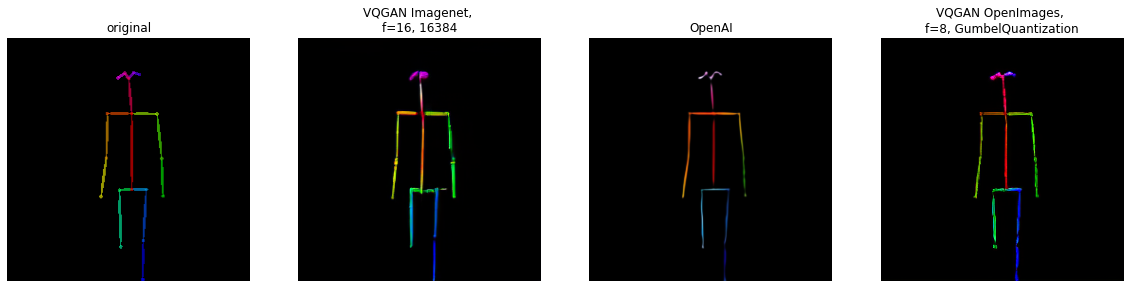

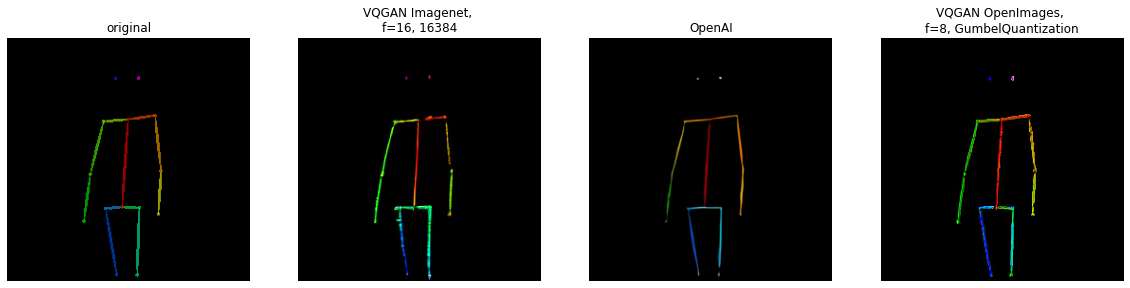

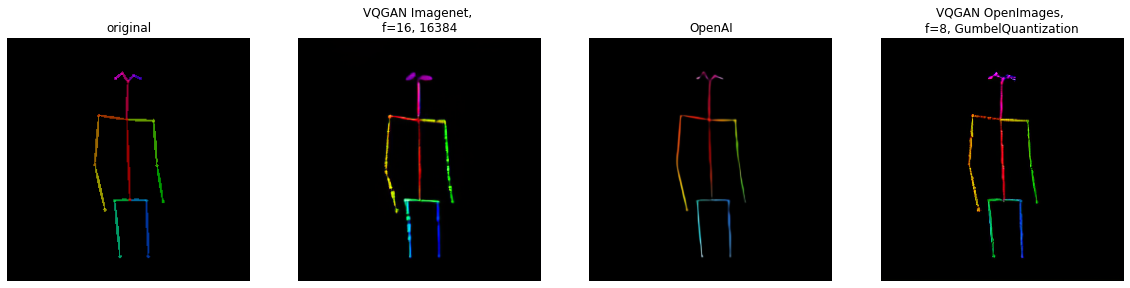

In [12]:
for i in range(12,15):
    image_fname = image_files[i]
    image = Image.open(image_fname)
    plot_image(image)